# Load libraries and data

Load libraries

In [120]:
import numpy as np 
import pandas as pd 
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)
from pandas.core.common import SettingWithCopyWarning
simplefilter(action="ignore", category=SettingWithCopyWarning)

Load data

In [121]:
X_test_test = pd.read_csv(r'C:\Users\macio\Documents\Python\Data Science\Kaggle_House_Pricing_Prediction\test.csv', index_col='Id')

In [122]:
X_all_data = pd.read_csv(r'C:\Users\macio\Documents\Python\Data Science\Kaggle_House_Pricing_Prediction\train.csv', index_col='Id')
X_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Preprocessing

Check null values

In [123]:
pd.DataFrame(X_all_data.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


Split data to x and y

In [124]:
y_all_data = X_all_data.SalePrice
X_all_data.drop(['SalePrice'], axis=1, inplace=True)
X_all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Split data to train/valid and test set

In [125]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all_data, y_all_data, train_size=0.85, test_size=0.15, random_state=1)

Get numerical and categorical columns (with less than 10 unique value)

In [126]:
categorical_cols = [cname for cname in X_train_valid.columns if
                    X_train_valid[cname].nunique() < 10 and 
                    X_train_valid[cname].dtype == "object"]

In [127]:
numerical_cols = [cname for cname in X_train_valid.columns if 
                X_train_valid[cname].dtype in ['int64', 'float64']]

In [128]:
my_cols = categorical_cols + numerical_cols
X_train_valid = X_train_valid[my_cols].copy()
X_test = X_test[my_cols].copy()
X_test_test = X_test_test[my_cols].copy()

In [129]:
num_col = X_train_valid._get_numeric_data()
cat_col = X_train_valid.select_dtypes('object')

Distribution of values in individual numerical columns.

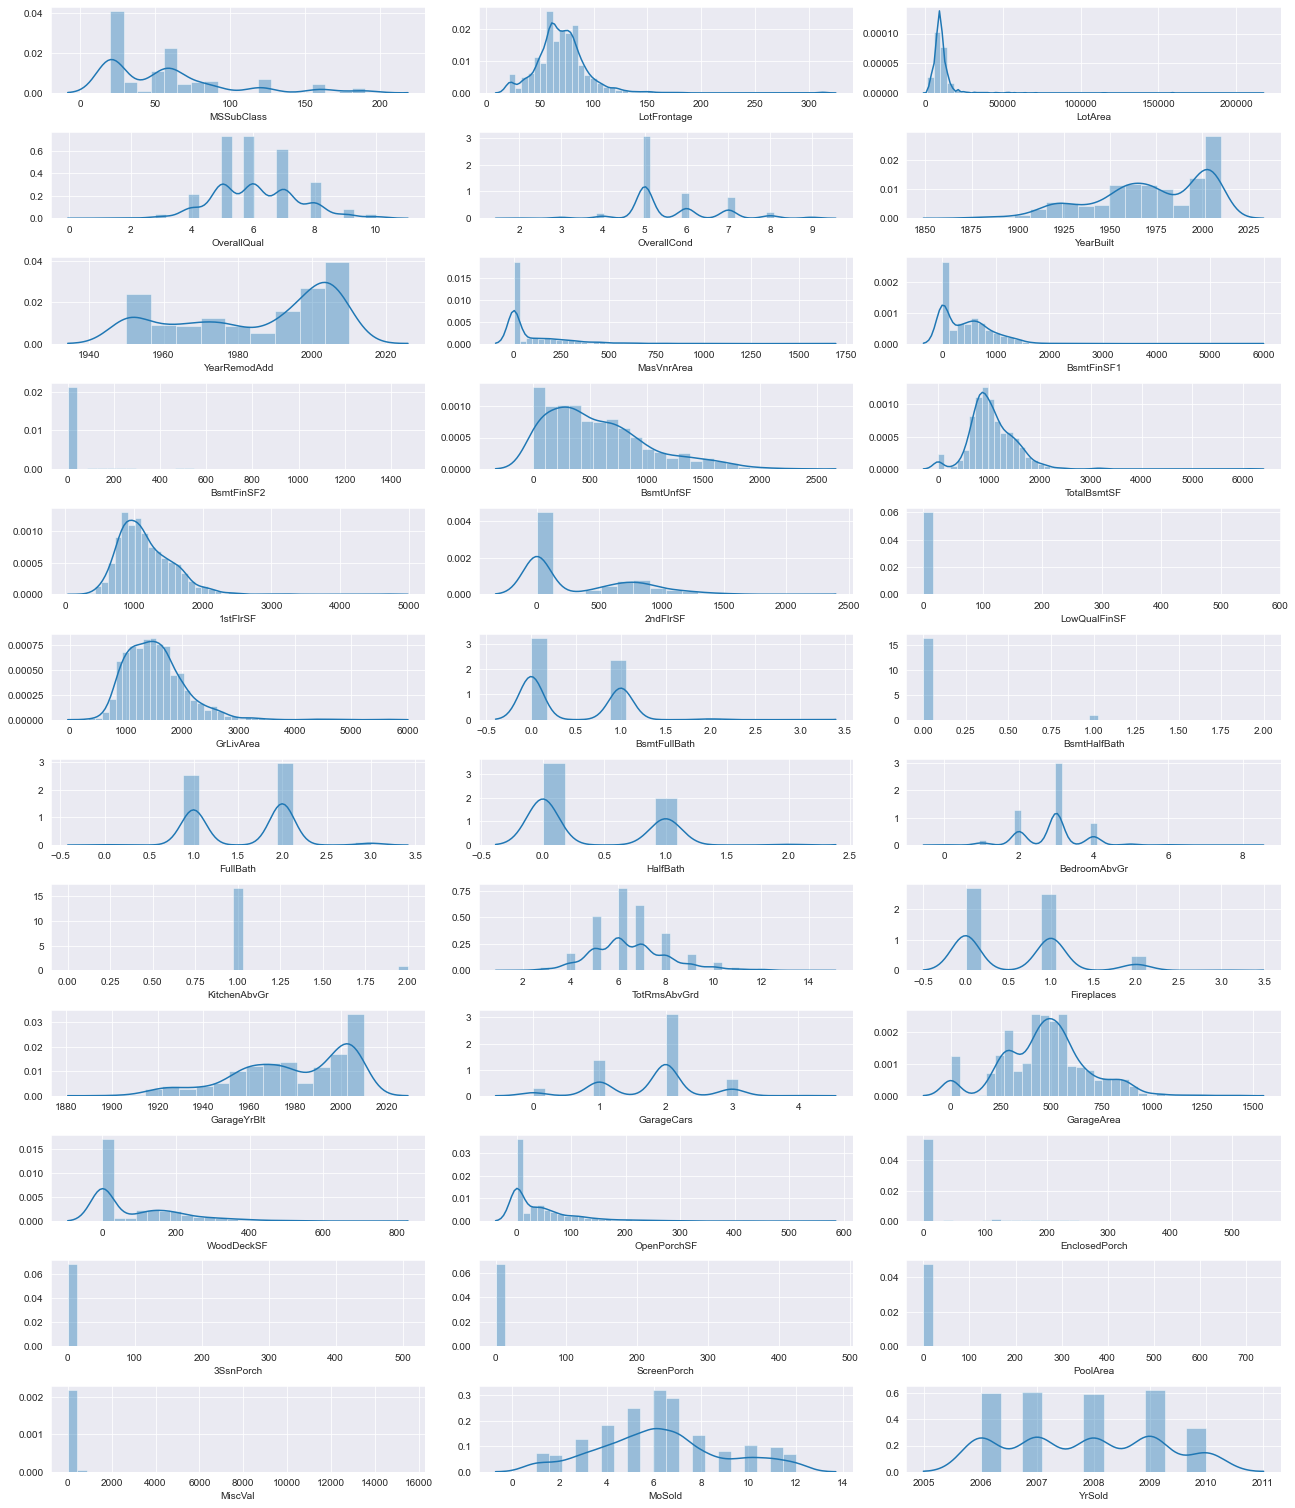

In [130]:
fig = plt.figure(figsize=(18, 55))
for index in range(len(num_col.columns)):
    plt.subplot(26,3,index+1)
    sns.distplot(num_col.iloc[:,index].dropna(), norm_hist=False)
fig.tight_layout(pad=1.0)

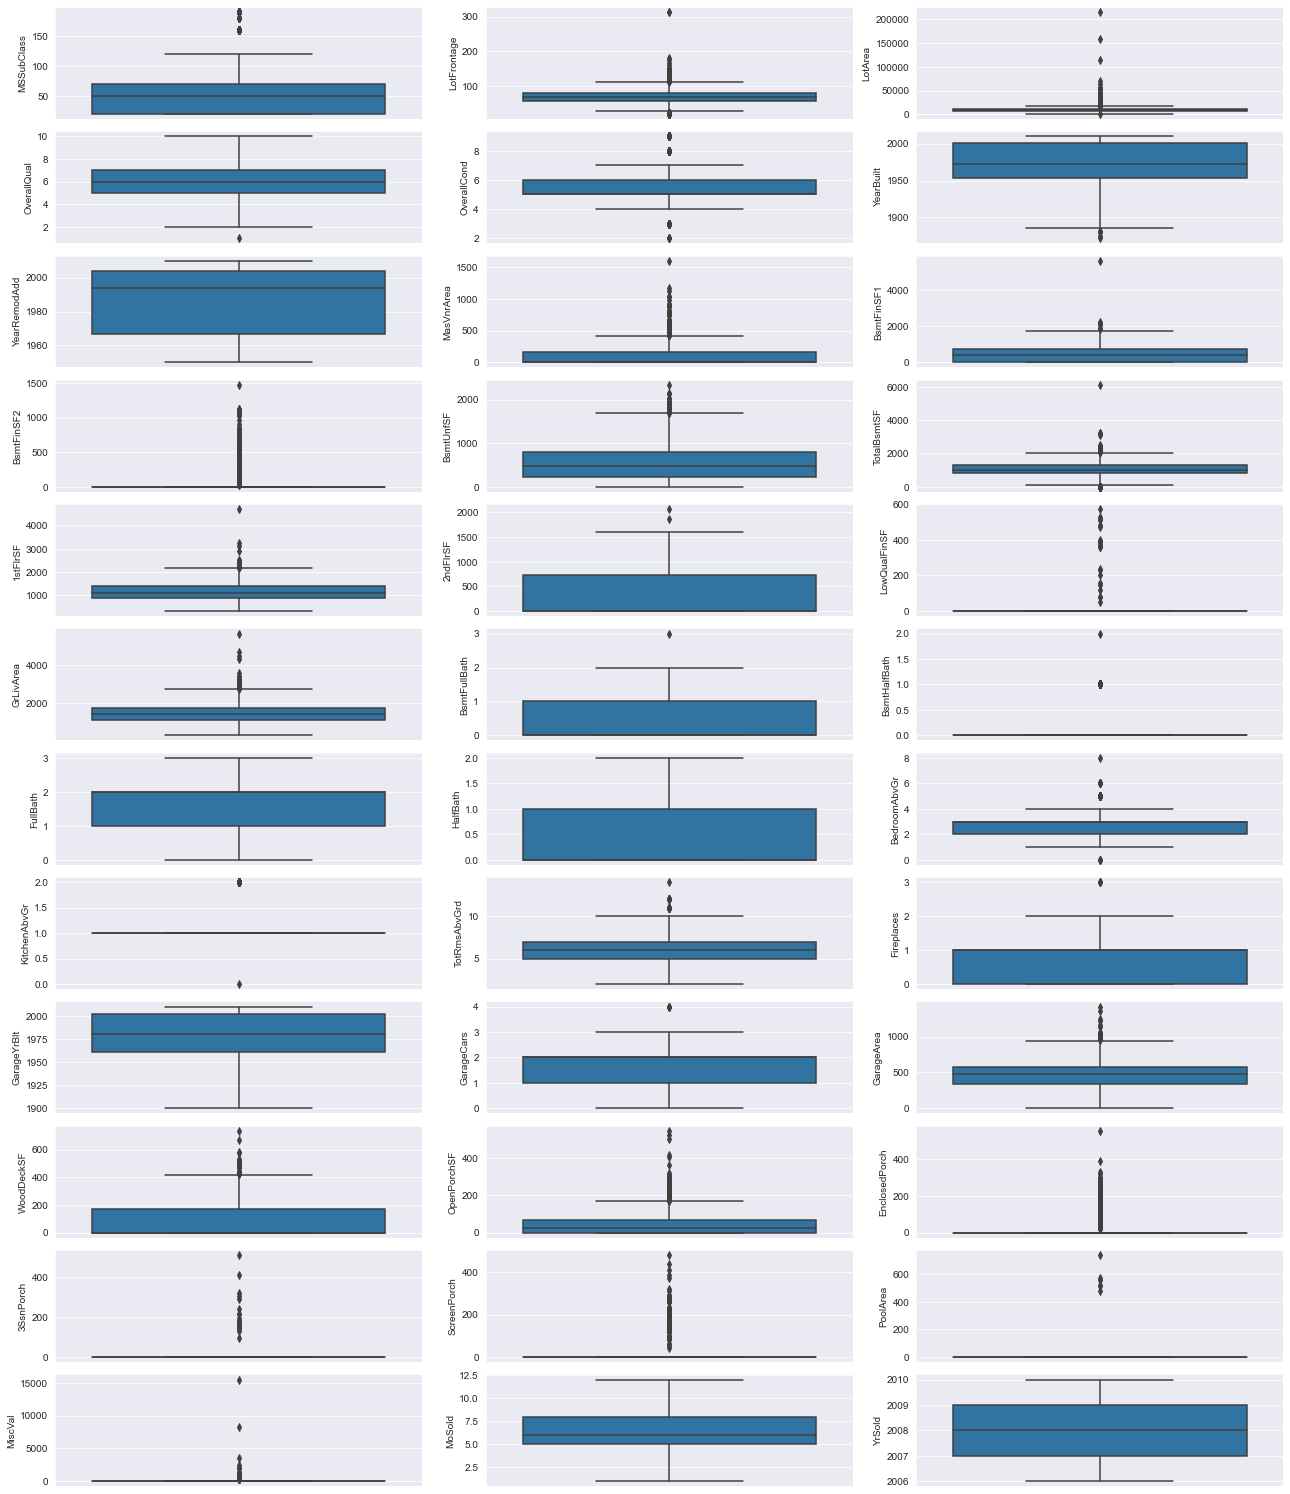

In [131]:
fig = plt.figure(figsize=(18, 55))
for index in range(len(num_col.columns)):
    plt.subplot(26,3,index+1)
    sns.boxplot(y=num_col.iloc[:,index], data=num_col.dropna())
fig.tight_layout(pad=1.0)

Distribution of values in categorical columns.

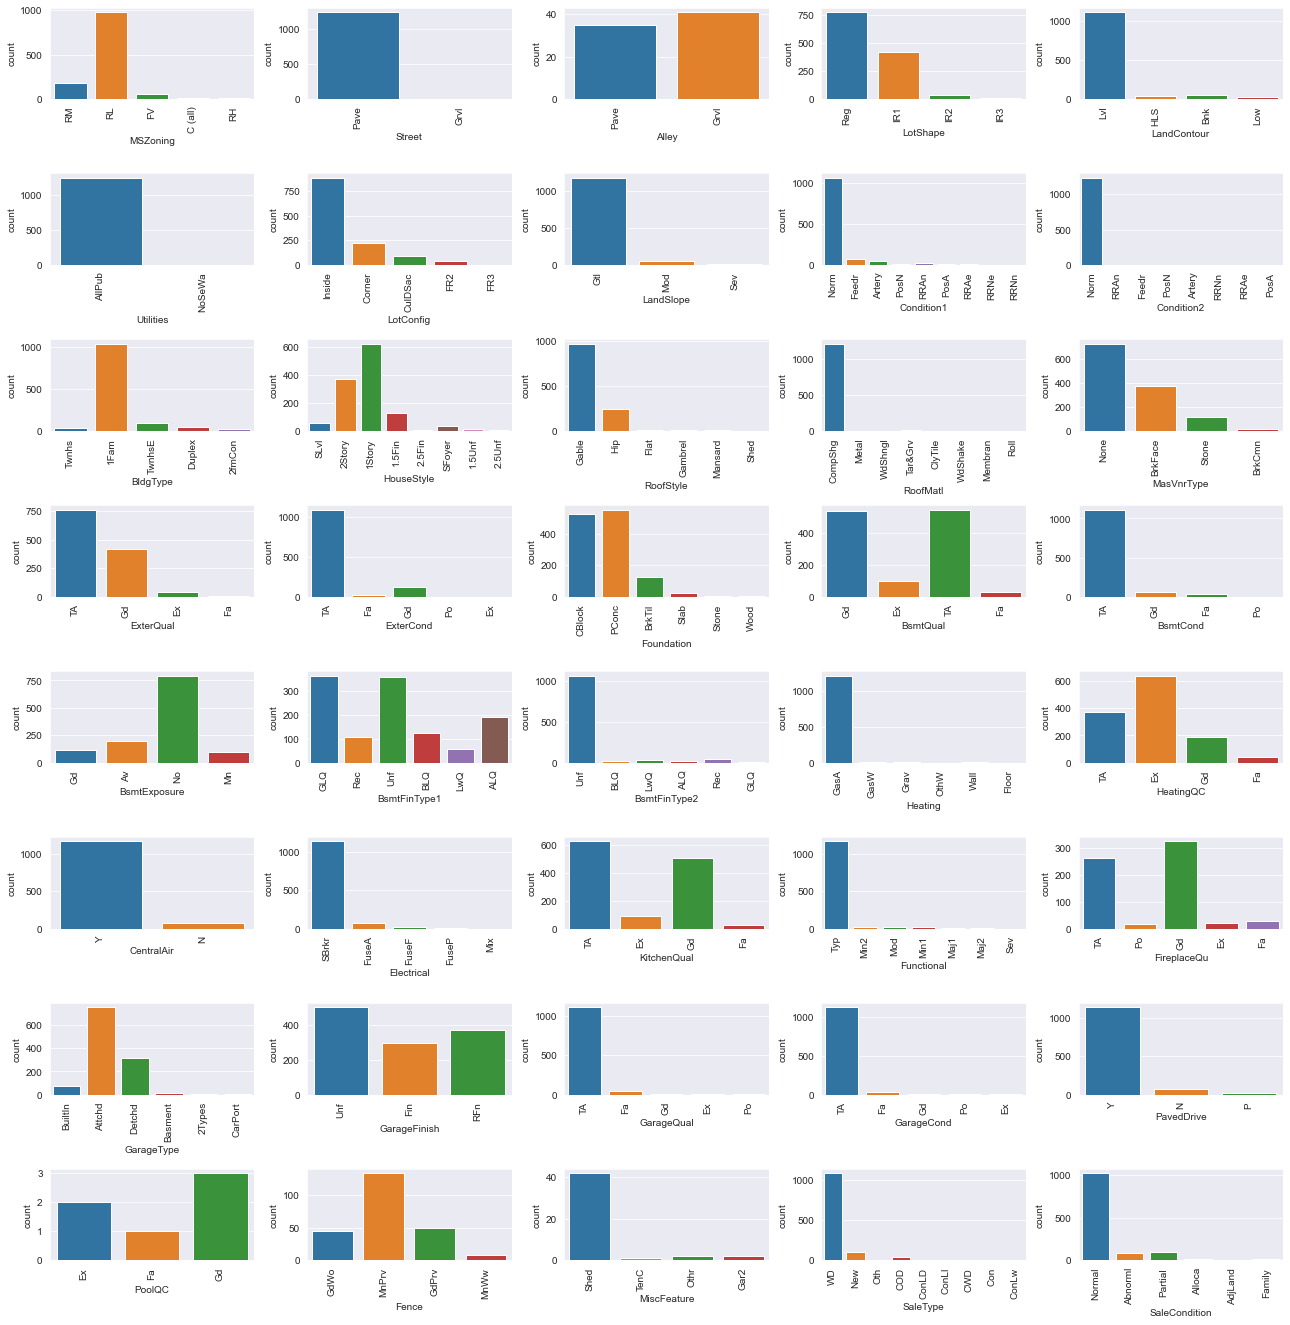

In [132]:
fig = plt.figure(figsize=(18, 55))
for index in range(len(cat_col.columns)):
    plt.subplot(15,3,index+1)
    sns.countplot(x=cat_col.iloc[:,index], data=cat_col.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

Caorrelation between numerical features

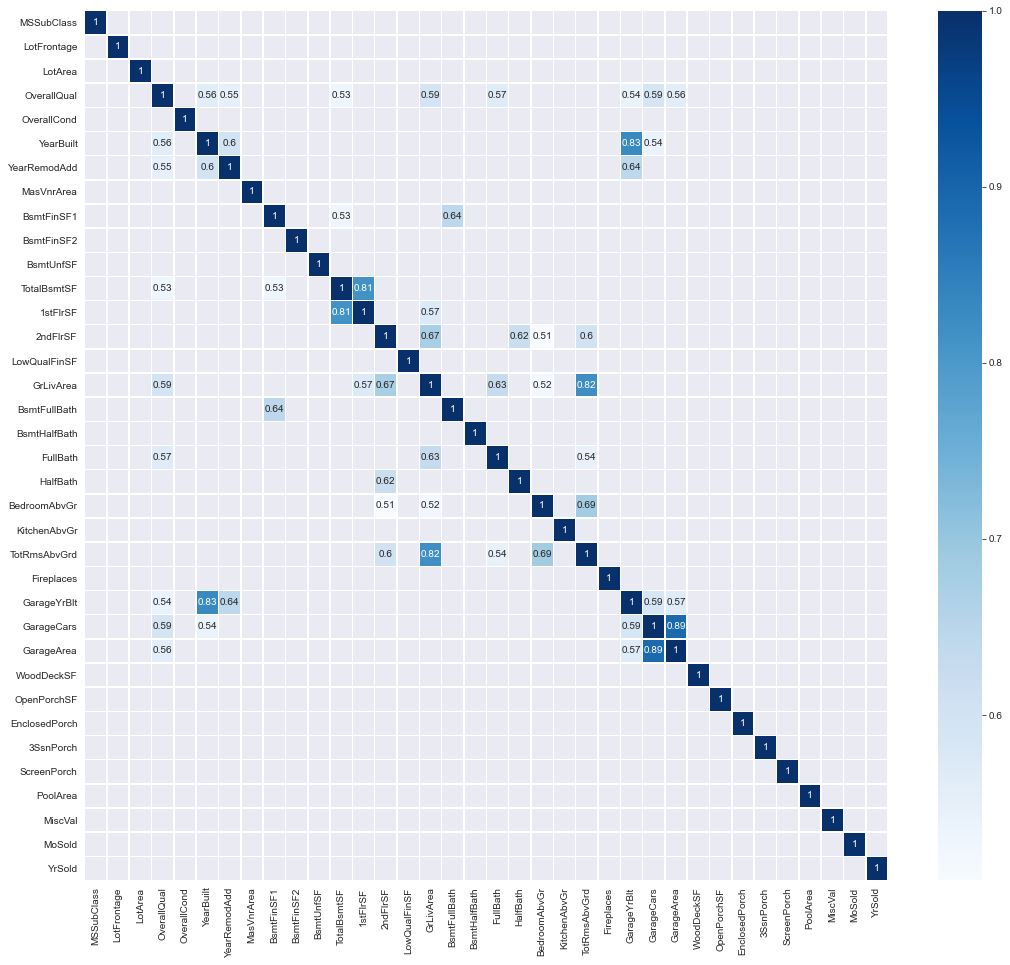

In [133]:
plt.figure(figsize=(18,16))
correlation = X_train_valid.corr()
sns.heatmap(correlation, mask = correlation <0.5, linewidth=0.5, cmap='Blues', annot=True)

Drop highly correlated, and with mostly one value features

In [134]:
X_train_valid.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars','PoolQC','MiscFeature','Alley',
                    'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating','LowQualFinSF', '3SsnPorch',
                    'PoolArea', 'MiscVal'], axis=1, inplace=True)
X_test.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars','PoolQC','MiscFeature','Alley',
             'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating','LowQualFinSF', '3SsnPorch',
             'PoolArea', 'MiscVal'], axis=1, inplace=True)
X_test_test.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars','PoolQC','MiscFeature','Alley',
                  'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating','LowQualFinSF', '3SsnPorch',
                  'PoolArea', 'MiscVal'], axis=1, inplace=True)

In [135]:
categorical_cols = [cname for cname in X_train_valid.columns if
                    X_train_valid[cname].dtype == "object"]
numerical_cols = [cname for cname in X_train_valid.columns if 
                X_train_valid[cname].dtype in ['int64', 'float64']]

# Classification model

In [136]:
kf = KFold(5, shuffle=True, random_state=1)

Function showing the results of a 5-fold model validation.

In [137]:
def evaluate_model(model, name):
    model_performances = pd.DataFrame({
        'Model' : [name],
        'Mean R2(val)' : round(model.cv_results_['mean_test_r2'][model.best_index_], 3),
        'Mean RMSE(val)': abs(round(model.cv_results_['mean_test_neg_root_mean_squared_error'][model.best_index_], 0)),
        'Mean MAE(val)': abs(round(model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_], 0)),
        'Fit time(val)': round(model.cv_results_['mean_fit_time'][model.best_index_], 3)
    })
    model_performances.set_index('Model', inplace=True, drop=True)
    return model_performances

Model LightGBM.

In [138]:
start = time.time()

numerical_transformer = SimpleImputer(strategy='most_frequent')

categorical_transformer = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                        ]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('scaling', RobustScaler()),
        ('model', LGBMRegressor())
    ])

param_lst_lgbm = {
    'model__max_depth' : [2, 3, 5, 7, 8],
    'model__num_leaves' : [3, 5, 20, 80, 180],
    'model__learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'model__n_estimators' : [100, 300, 500, 1000, 1500, 2000],
    'model__reg_alpha' : [0.001, 0.01, 1, 10, 100],
    'model__reg_lambda' : [0.001, 0.01, 1, 10, 100],
    'model__colsample_bytree' : [0.5, 0.7, 0.8],
    'model__min_child_samples' : [5, 10, 20, 25],
}

lgbm_cv = RandomizedSearchCV(estimator = lgbm,
                              param_distributions = param_lst_lgbm,
                              n_iter = 100,
                              scoring = ['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                              refit = 'neg_mean_absolute_error',
                              cv = kf,
                              n_jobs = -1)
       
lgbm_search = lgbm_cv.fit(X_train_valid, y_train_valid)

best_param_lgbm = lgbm_search.best_params_
end = time.time()
time_lgbm = round(end-start, 0)
print('Dobrane parametry dla modelu LGBM: ', best_param_lgbm)
print('Czas dopierania parametrów: ', time_lgbm, ' [sek]')

Dobrane parametry dla modelu LGBM:  {'model__reg_lambda': 0.001, 'model__reg_alpha': 0.01, 'model__num_leaves': 180, 'model__n_estimators': 1000, 'model__min_child_samples': 5, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.5}
Czas dopierania parametrów:  35.0  [sek]


In [139]:
cv_lgbm = evaluate_model(lgbm_search,  'LGBM')
print(cv_lgbm)

       Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                            
LGBM          0.845         30085.0        16529.0          2.789


# Results

A function that presents the results of regression on a test set.

In [140]:
def evaluate_model_test(model, X, y, name):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    score = r2_score(y, pred)
    model_performances_test = pd.DataFrame({
        'Model' : [name],
        'R2(test)' : round(score, 3),
        'RMSE(test)': round(rmse, 0),
        'MAE(test)': round(mae, 0),
        'Predict time' : round(end-start, 4)
    })
    model_performances_test.set_index('Model', inplace=True, drop=True)
    return model_performances_test

Comparison of the results obtained on the test set and on the validation sets.

In [141]:
test_lgbm = evaluate_model_test(lgbm_search, X_test, y_test, 'LGBM')
results_all = pd.concat([cv_lgbm, test_lgbm ], axis=1)
results_all.head()

,Mean R2(val),Mean RMSE(val),Mean MAE(val),Fit time(val),R2(test),RMSE(test),MAE(test),Predict time
Model,,,,,,,,
LGBM,0.845,30085.0,16529.0,2.789,0.939,19881.0,13201.0,0.016


Effect of features on the result

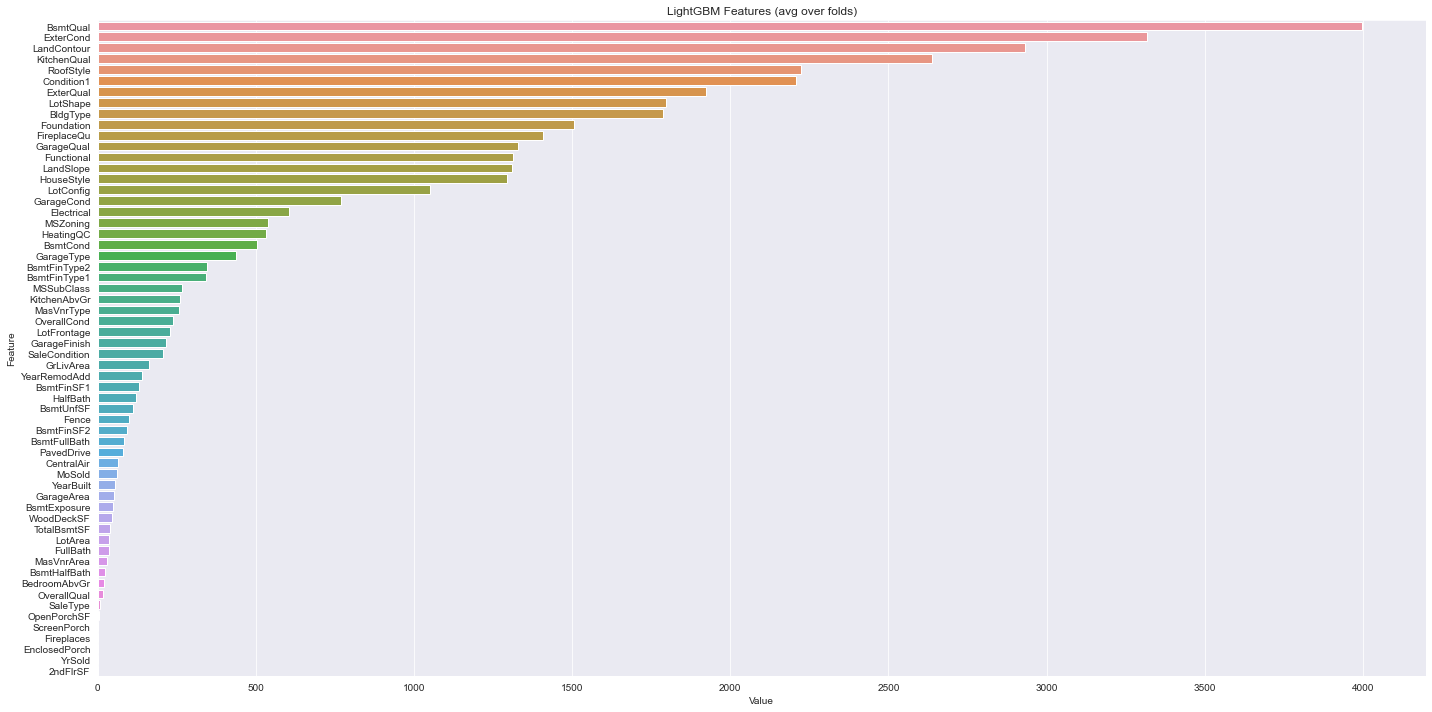

In [142]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_search.best_estimator_.named_steps['model'].feature_importances_,X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

Code to subimit results on kaggle

In [143]:
# output = pd.DataFrame({'Id': X_test.index,
#                        'SalePrice': pred = model.predict(X_test_test)})
# output.to_csv('submission.csv', index=False)